In [1]:
import itertools as itr
import os
from tqdm import tqdm
from collections import defaultdict

import causaldag as cd
from strategies.simulator import IterationData
from strategies.information_gain import create_info_gain_strategy

from utils import graph_utils
from analysis.check_gies import get_parent_probs_by_dag, get_l1_score

from config import DATA_FOLDER
samples_folder = os.path.join(DATA_FOLDER, 'check-interventions', 'samples')
os.makedirs(samples_folder, exist_ok=True)

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import numpy as np
import xarray as xr
from sklearn import preprocessing

In [3]:
IV_STRENGTH = 5
nnodes = 10
density = .5
target = int(np.ceil(nnodes/2))
nsamples = 2000
N_BOOT = 100
runs = 3
nsamples_obs = 1000
target

5

In [4]:
def tuplify(s):
    a, b = s.split(',')
    return (int(a), int(b))

def detuplify(t):
    a, b = t
    return '%s,%s' % (a, b)

print(tuplify('1,2'))
print(detuplify((1, 2)))

(1, 2)
1,2


In [5]:
np.random.seed(0)
true_dag = cd.rand.directed_erdos(nnodes, density)
true_arcs = {(i+1, i) for i in range(nnodes-1)}
true_dag = cd.DAG(nodes=set(range(nnodes)), arcs=true_arcs)

In [6]:
arcs = {(i, j): 1 for i, j in true_dag.arcs}
gdag = cd.GaussDAG(nodes=list(range(nnodes)), arcs=arcs)
obs_samples = [preprocessing.scale(gdag.sample(nsamples_obs)) for run in range(runs)]
np.diag(np.cov(obs_samples[0], rowvar=False))

array([1.001001, 1.001001, 1.001001, 1.001001, 1.001001, 1.001001,
       1.001001, 1.001001, 1.001001, 1.001001])

## Plot the graph

In [7]:
def draw_colored(gdag):
    cmap = plt.get_cmap('seismic')
    
    nw_ax = plt.subplot2grid((10, 10), (0, 0), colspan=9, rowspan=9)
    colorbar_ax = plt.subplot2grid((10, 10), (2, 9), rowspan=6)
    
    plt.gcf().set_size_inches(10, 10)
    d = nx.DiGraph()
    for (i, j), w in gdag.arc_weights.items():
        d.add_edge(i, j, weight=w)
    pos = graphviz_layout(d, 'dot')
    edges = d.edges()
    edge_colors = [(cmap((d[i][j]['weight']+1)/2)) for i, j in edges]
    nx.draw(d, pos=pos, node_color='w', edge_color=edge_colors, ax=nw_ax)
    nx.draw_networkx_labels(d, pos, labels={node: node for node in range(10)}, ax=nw_ax);
    
    cb = mpl.colorbar.ColorbarBase(colorbar_ax, cmap=cmap, orientation='vertical')
    cb.set_ticks([0, .5, 1])
    cb.set_ticklabels([-1, 0, 1])

[9][8|9][7|8][6|7][5|6][4|5][3|4][2|3][1|2][0|1]


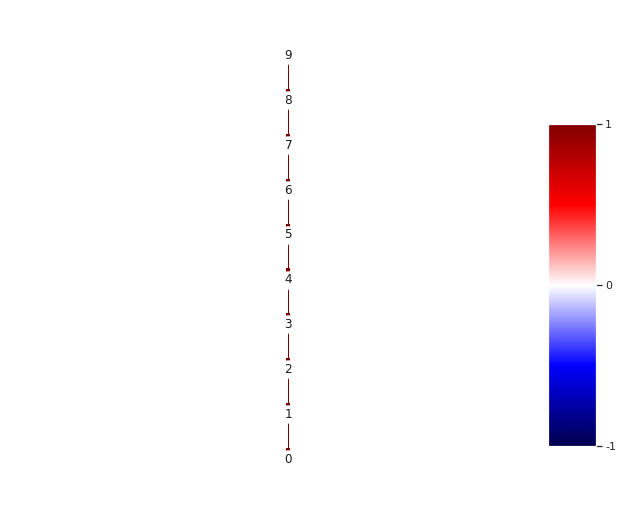

In [8]:
draw_colored(gdag)
print(str(gdag))

In [9]:
g = nx.Graph()
cpdag = true_dag.cpdag()
cpdag.edges

{(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)}

In [10]:
for iv in range(10):
    icpdag = true_dag.interventional_cpdag({iv}, cpdag=cpdag)
    print(iv, ':', icpdag.edges)

0 : {(1, 2), (6, 7), (4, 5), (5, 6), (8, 9), (2, 3), (3, 4), (7, 8)}
1 : {(8, 9), (7, 8), (6, 7), (5, 6), (2, 3), (4, 5), (3, 4)}
2 : {(8, 9), (7, 8), (6, 7), (5, 6), (4, 5), (3, 4)}
3 : {(8, 9), (6, 7), (5, 6), (4, 5), (7, 8)}
4 : {(8, 9), (7, 8), (5, 6), (6, 7)}
5 : {(8, 9), (7, 8), (6, 7)}
6 : {(8, 9), (7, 8)}
7 : {(8, 9)}
8 : set()
9 : set()


In [11]:
intervention_nodes = list(range(nnodes))
interventions = [
    cd.BinaryIntervention(
        intervention1=cd.ConstantIntervention(val=-IV_STRENGTH*std),
        intervention2=cd.ConstantIntervention(val=IV_STRENGTH*std),
    ) for std in np.diag(gdag.covariance)**.5
]

In [12]:
ivs2dags = defaultdict(list)

# Collect DAGs given just observational data

In [13]:
for run in tqdm(range(runs)):
    folder = os.path.join(samples_folder, 'observational,run%d' % run)
    os.makedirs(folder)
    samples_file = os.path.join(folder, 'samples.csv')
    interventions_folder = os.path.join(folder, 'interventions')
    gies_dags_folder = os.path.join(folder, 'gies_dags/')

    graph_utils._write_data({-1: obs_samples[run]}, samples_file, interventions_folder)
    graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)
    amats, dags = graph_utils._load_dags(gies_dags_folder)

    ivs2dags[-1].append(dags)

100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


# Collect DAGs given interventional data

In [14]:
for iv_node, intervention in tqdm(zip(intervention_nodes, interventions), total=len(interventions)):
    for run in range(runs):
        samples = gdag.sample_interventional({iv_node: intervention}, nsamples)
        samples = preprocessing.scale(samples)
        all_samples = {-1: obs_samples[run], iv_node: samples}
        folder = os.path.join(samples_folder, 'iv=%d,run%d' % (iv_node, run))
        os.makedirs(folder)

        samples_file = os.path.join(folder, 'samples.csv')
        interventions_folder = os.path.join(folder, 'interventions')
        gies_dags_folder = os.path.join(folder, 'gies_dags/')
        graph_utils._write_data(all_samples, samples_file, interventions_folder)
        graph_utils.run_gies_boot(N_BOOT, samples_file, interventions_folder, gies_dags_folder)

        amats, dags = graph_utils._load_dags(gies_dags_folder)
        ivs2dags[iv_node].append(dags)

100%|██████████| 10/10 [01:30<00:00,  9.03s/it]


# Count the occurrences of each arc in the sampled DAGs

In [15]:
ivs2parent_probs = xr.DataArray(
    np.zeros([len(interventions) + 1, len(gdag.nodes), runs]),
    dims=['iv_node', 'parent', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'parent': gdag.nodes,
        'run': list(range(runs))
    }
)
possible_arcs = list(itr.permutations(gdag.nodes, 2))
ivs2arc_probs = xr.DataArray(
    np.zeros([len(interventions) + 1, len(possible_arcs), runs]),
    dims=['iv_node', 'arc', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'arc': list(map(detuplify, possible_arcs)),
        'run': list(range(runs))
    }
)
for iv_node, dags_by_run in ivs2dags.items():
    for run, dags in enumerate(dags_by_run):
        parent_counts = {node: 0 for node in gdag.nodes}
        arc_counts = defaultdict(int)
        for dag in dags:
            for p in dag.parents[target]:
                parent_counts[p] += 1
            for arc in dag.arcs:
                arc_counts[arc] += 1
        for parent, count in parent_counts.items():
            ivs2parent_probs.loc[dict(run=run, iv_node=iv_node, parent=p)] = count/len(dags)
        for arc, count in arc_counts.items():
            ivs2arc_probs.loc[dict(run=run, iv_node=iv_node, arc=detuplify(arc))] = count/len(dags)

# From the arc occurrences, compute l1 scores

#### functions

In [61]:
def l1_score_full(arc_probs, gdag):
    possible_arcs = set(itr.permutations(gdag.nodes, 2))
    nonarcs = possible_arcs - gdag.arcs
    return sum(1-arc_probs[arc] for arc in gdag.arcs) + sum(arc_probs[nonarc] for nonarc in nonarcs)


def l1_score_fp_full(arc_probs, gdag):
    possible_arcs = set(itr.permutations(gdag.nodes, 2))
    nonarcs = possible_arcs - gdag.arcs
    return sum(arc_probs[nonarc] for nonarc in nonarcs)


def l1_score_fn_full(arc_probs, gdag):
    return sum(1-arc_probs[arc] for arc in gdag.arcs)

#### actual computation

In [82]:
ivs2scores = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
for iv_node in intervention_nodes + [-1]:
    for run in range(runs):
        parent_probs = {node: ivs2parent_probs.sel(iv_node=iv_node, parent=node, run=run) for node in gdag.nodes}
        ivs2scores.loc[dict(iv_node=iv_node, run=run)] = get_l1_score(parent_probs, gdag, target)

max_l1_loss_full = nnodes*(nnodes-1)
max_l1_loss_fn = len(gdag.arcs)
max_l1_loss_fp = max_l1_loss_full - max_l1_loss_fn
ivs2full_scores = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
ivs2full_scores_fp = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
ivs2full_scores_fn = xr.DataArray(
    np.zeros([len(interventions) + 1, runs]),
    dims=['iv_node', 'run'],
    coords={
        'iv_node': [-1] + intervention_nodes,
        'run': list(range(runs))
    }
)
for iv_node in intervention_nodes + [-1]:
    for run in range(runs):
        arc_probs = {arc: ivs2arc_probs.sel(iv_node=iv_node, arc=detuplify(arc), run=run).values.item() for arc in possible_arcs}
        ivs2full_scores.loc[dict(iv_node=iv_node, run=run)] = l1_score_full(arc_probs, gdag)
        ivs2full_scores_fp.loc[dict(iv_node=iv_node, run=run)] = l1_score_fp_full(arc_probs, gdag)
        ivs2full_scores_fn.loc[dict(iv_node=iv_node, run=run)] = l1_score_fn_full(arc_probs, gdag)

        

# Plot effectiveness of each intervention

#### L1-score targeting just learning parents

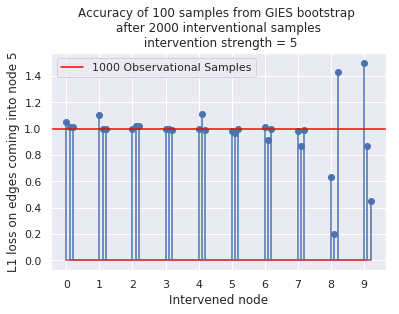

In [63]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2scores.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2scores.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2scores.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2scores.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss on edges coming into node 5')
plt.legend();

#### L1-score on full graph

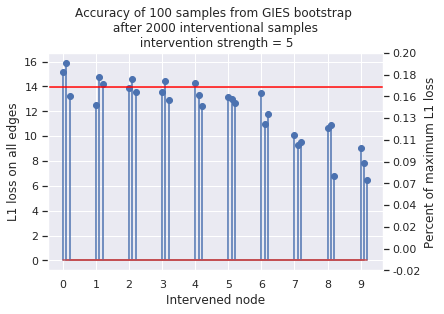

In [88]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss on all edges')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_full), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

#### L1-score on false negatives

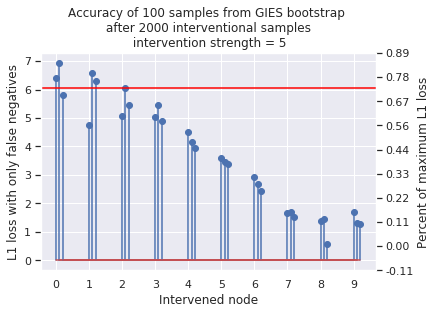

In [91]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores_fn.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores_fn.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss with only false negatives')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_fn), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

#### L1-score on false positives

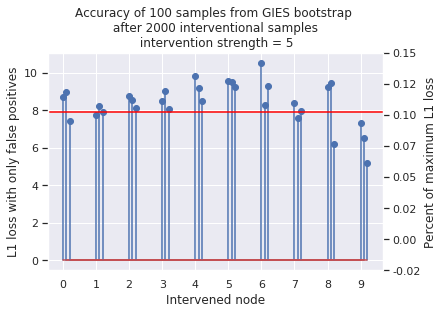

In [89]:
plt.title('Accuracy of %d samples from GIES bootstrap \n after %d interventional samples \n intervention strength = %s' % (N_BOOT, nsamples, IV_STRENGTH))
plt.stem(intervention_nodes, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=0))
plt.stem(np.array(intervention_nodes) + .1, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=1))
plt.stem(np.array(intervention_nodes) + .2, ivs2full_scores_fp.sel(iv_node=intervention_nodes,run=2))

plt.axhline(ivs2full_scores_fp.sel(iv_node=-1, run=2), color='red', label='%d Observational Samples' % nsamples_obs)
plt.xlabel('Intervened node')
plt.xticks(gdag.nodes)
plt.ylabel('L1 loss with only false positives')

# A bunch of annoying code to get right-hand yaxis lookin' nice
ax1 = plt.gca()
yticks, _ = plt.yticks()
ax = plt.twinx()
ax.set_yticks(yticks)
ax.set_yticklabels(map(lambda y: '%.2f' % (y / max_l1_loss_fp), yticks))
ax.grid(False)
ax.set_ylabel('Percent of maximum L1 loss')

plt.legend();

In [22]:
# def get_parent_functional(parent):
#     def parent_functional(dag):
#         return parent in dag.parents[target]
#     return parent_functional

# parent_functionals = [get_parent_functional(node) for node in gdag.nodes if node != target]

In [23]:
# info_strat = create_info_gain_strategy(50, parent_functionals)
# info_strat_folder = os.path.join(samples_folder, 'info/')
# os.makedirs(info_strat_folder)
# iteration_data = IterationData(
#     current_data={-1: obs_samples},
#     max_interventions=1,
#     n_samples=n,
#     batch_num=1,
#     n_batches=1,
#     intervention_set=intervention_nodes,
#     interventions=interventions,
#     batch_folder=info_strat_folder,
#     precision_matrix=gdag.precision
# )
# info_strat(iteration_data)

In [24]:
ivs2parent_probs.sel(iv_node=0, run=1)

<xarray.DataArray (parent: 10)>
array([0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ])
Coordinates:
    iv_node  int64 0
  * parent   (parent) int64 0 1 2 3 4 5 6 7 8 9
    run      int64 1

In [25]:
ivs2parent_probs.sel(iv_node=0, run=2)

<xarray.DataArray (parent: 10)>
array([0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ])
Coordinates:
    iv_node  int64 0
  * parent   (parent) int64 0 1 2 3 4 5 6 7 8 9
    run      int64 2

In [26]:
ivs2scores.sel(iv_node=0, run=1)

<xarray.DataArray ()>
array(1.01)
Coordinates:
    iv_node  int64 0
    run      int64 1

In [27]:
ivs2scores.sel(iv_node=0, run=2)

<xarray.DataArray ()>
array(1.01)
Coordinates:
    iv_node  int64 0
    run      int64 2

In [28]:
ivs2scores.sel(iv_node=0, run=0)

<xarray.DataArray ()>
array(1.05)
Coordinates:
    iv_node  int64 0
    run      int64 0

In [29]:
def marginal_network(ivs2arc_probs, iv, run, mode='both'):
    arc_probs = ivs2arc_probs.sel(iv_node=iv, run=run)
    d = nx.DiGraph()
    d.add_nodes_from(gdag.nodes)
    for arc, prob in zip(possible_arcs, arc_probs.data):
        i, j = arc
        if prob != 0:
            if mode == 'both' or (mode == 'forward' and i<j) or (mode == 'backward' and i > j):
                d.add_edge(*arc, weight=prob)
    return d

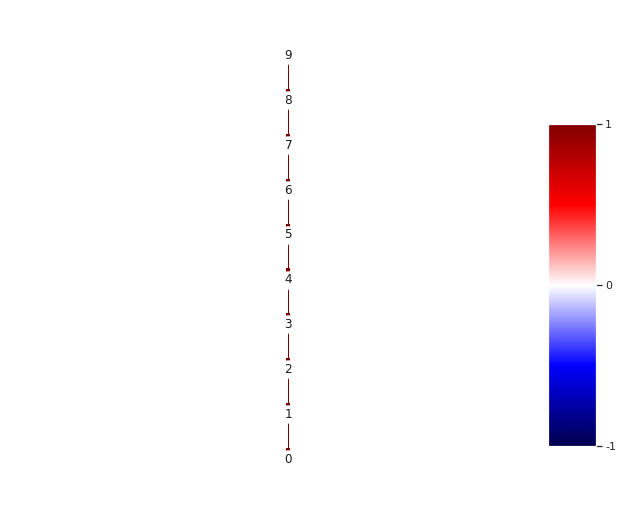

In [30]:
draw_colored(gdag)

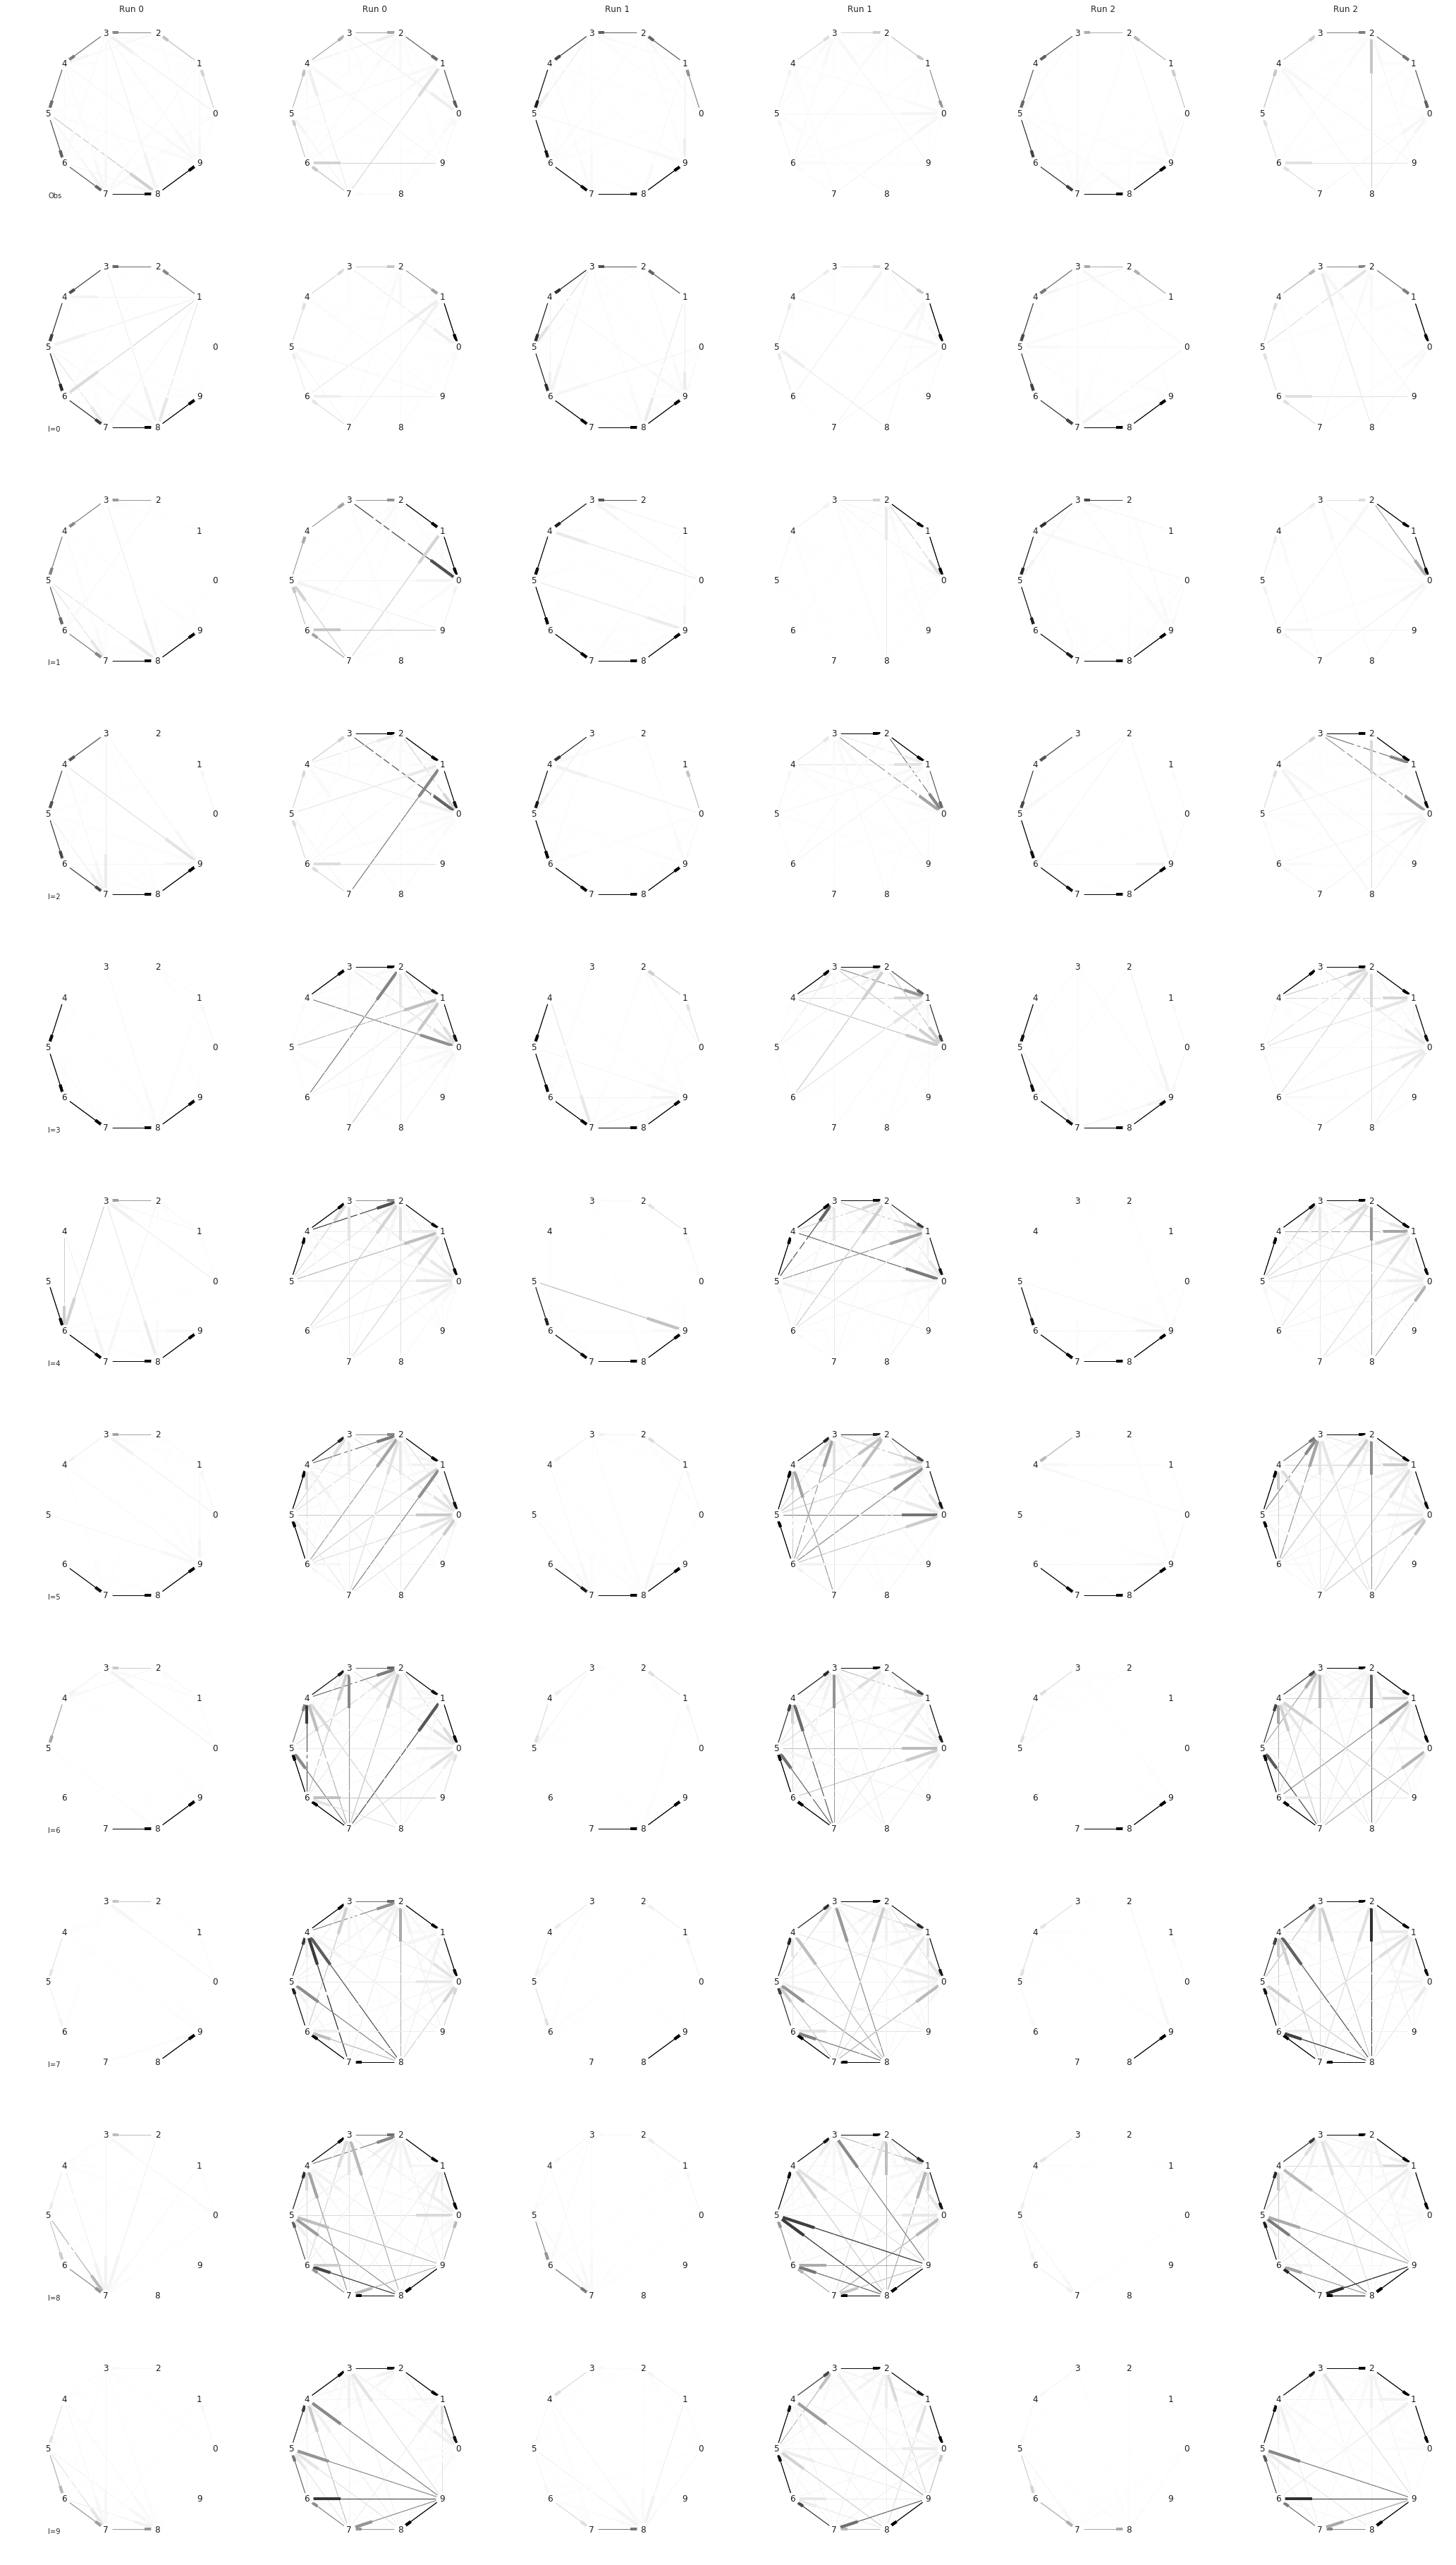

In [31]:
cmap = plt.get_cmap('Greys')
fig, axes = plt.subplots(len(interventions)+1, runs*2)
unit = 6
width = unit*runs*2
height = unit*(len(interventions) + 1)
fig.set_size_inches(width, height)

pos = nx.circular_layout(gdag.nodes)

for run in range(runs):
    for iv_ix, iv_node in enumerate([-1] + intervention_nodes):
        forward_ax = axes[iv_ix, run*2]
        backward_ax = axes[iv_ix, run*2+1]
        
        m = marginal_network(ivs2arc_probs, iv_node, run, mode='forward')
        edges = m.edges()
        edge_colors = [cmap(m[i][j]['weight']) for i, j in edges]
        nx.draw(m, pos=pos, node_color='w', edge_color=edge_colors, ax=forward_ax)
        nx.draw_networkx_edges(m, pos, edge_color=edge_colors, ax=forward_ax, arrowstyle='fancy')
        nx.draw_networkx_labels(m, pos, labels={node: node for node in range(10)}, ax=forward_ax)
        
        m = marginal_network(ivs2arc_probs, iv_node, run, mode='backward')
        edges = m.edges()
        edge_colors = [cmap(m[i][j]['weight']) for i, j in edges]
        nx.draw(m, pos=pos, node_color='w', edge_color=edge_colors, ax=backward_ax)
        nx.draw_networkx_edges(m, pos, edge_color=edge_colors, ax=backward_ax, arrowstyle='fancy')
        nx.draw_networkx_labels(m, pos, labels={node: node for node in range(10)}, ax=backward_ax);
        
        if iv_ix == 0:
            forward_ax.set_title('Run %d' % run)
            backward_ax.set_title('Run %d' % run)
        if run == 0:
            forward_ax.text(-1, -1, 'I=%s' % iv_node if iv_node != -1 else 'Obs')

In [32]:
gdag.arcs

{(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (6, 5), (7, 6), (8, 7), (9, 8)}

In [46]:
ivs2full_scores_fp

<xarray.DataArray (iv_node: 11, run: 3)>
array([[3.24, 0.81, 0.81],
       [4.86, 0.  , 0.81],
       [0.  , 2.43, 0.  ],
       [0.81, 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [3.24, 1.62, 0.  ],
       [1.62, 0.  , 0.81]])
Coordinates:
  * iv_node  (iv_node) int64 -1 0 1 2 3 4 5 6 7 8 9
  * run      (run) int64 0 1 2

In [48]:
ivs2full_scores_fn

<xarray.DataArray (iv_node: 11, run: 3)>
array([[5.71, 7.44, 6.07],
       [6.42, 6.94, 5.8 ],
       [4.77, 6.57, 6.29],
       [5.08, 6.06, 5.44],
       [5.03, 5.44, 4.88],
       [4.5 , 4.15, 3.94],
       [3.59, 3.44, 3.39],
       [2.94, 2.7 , 2.45],
       [1.67, 1.69, 1.51],
       [1.4 , 1.46, 0.56],
       [1.71, 1.33, 1.29]])
Coordinates:
  * iv_node  (iv_node) int64 -1 0 1 2 3 4 5 6 7 8 9
  * run      (run) int64 0 1 2

In [50]:
ivs2full_scores

<xarray.DataArray (iv_node: 11, run: 3)>
array([[30.01, 13.92, 23.08],
       [17.76, 19.9 , 22.81],
       [32.31,  7.38, 15.2 ],
       [23.71,  8.49,  9.49],
       [ 7.46,  7.06,  8.93],
       [ 5.31, 13.87,  9.61],
       [84.59, 84.44, 84.39],
       [83.94, 83.7 , 83.45],
       [75.38, 66.49, 78.46],
       [57.29, 41.96, 73.46],
       [51.12, 77.47, 59.61]])
Coordinates:
  * iv_node  (iv_node) int64 -1 0 1 2 3 4 5 6 7 8 9
  * run      (run) int64 0 1 2